In [1]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt

# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## Case study: applying binary logistic regression to the Iris dataset


The notebook will apply logistic classification to the __[Iris dataset](https://en.wikipedia.org/wiki/Iris_flower_data_set)__. For information about the logistic classification model see [here](classification_logistic_regression_model.ipynb) and for information about maximum-likelihood fitting see [here](classification_logistic_regression_ML_fitting.ipynb).

The task is to classify the variety of Iris flower based on measurements of its sepal length, sepal width, petal length and petal width. The input $\mathbf{x}$ is therefore four dimensional. The full problem involves three varieties of Iris (iris setosa, viridia or virginica), but here we consider just the first two classes so we can model this as a binary classification problem where $y=1 \; \text{or} \; 0$. 

Here's a set of pairwise plots showing the data plotted in terms of pairs of inputs. 
<div class="row">
  <div class="column">
<img src="iris_matrix_2D_mod.svg" alt="Snow" style="width:60%; float: center; padding: 50px">
</div>
  </div>
  We have already written all the code that we need to train logistic classification on these data (see [here](classification_logistic_regression_ML_fitting.ipynb)). Below we recapitulate the functions that implement the logistic function and gradient ascent.

In [2]:
def sig(x):
    
    return 1/(1 + np.exp(-x)) # define logistic function for convenience

def gradient_ascent(x, y, init_weights, no_steps, stepsize): # x: train inputs, y: train labels, rest self explanatory
    
    x = np.append(np.ones(shape = (x.shape[0], 1)), x, axis = 1) # add 1's to the inputs as usual
    
    w = init_weights.copy() # copy weights (to prevent changing init_weights as a side-effect - don't dwell on this)
    
    w_history, log_liks = [], [] # arrays for storing weights and log-liklihoods at each step
    
    for n in range(no_steps): # in this part we optimise log-lik w.r.t. w
        
        log_liks.append(np.sum(y * np.log(sig(x.dot(w))) + (1 - y) * np.log(1 - sig(x.dot(w))))) # record current log-lik
        
        w_history.append(w.copy()) # record current weights (use w.copy() to prevent aliasing - don't dwell on this)
    
        sigs = sig(x.dot(w)) # using our neat convenience function
        
        dL_dw = np.mean((y - sigs)*x.T, axis = 1) # calculate gradient of log-likelihood w.r.t. w
        
        w += stepsize * dL_dw # update weights and repeat
    
    return np.array(w_history), np.array(log_liks) 

toggle_code("gradient ascent algorithm")

Now we can load the Iris data, remove the third class, split into training and testing sets (75:25), and apply the algorithm: 

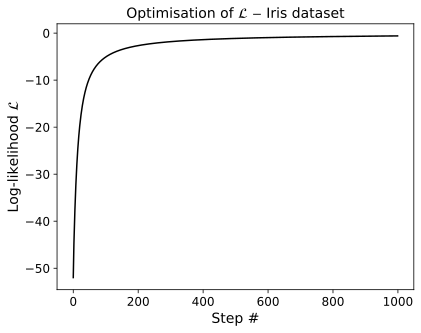

In [3]:
x = np.load('iris_inputs_full.npy')
y = np.load('iris_labels.npy')

x = x[np.where(np.logical_not(y == 2))[0]] 
y = y[np.where(np.logical_not(y == 2))[0]] # removing the datapoints of class 2

no_train = (x.shape[0]*3)//4
x_train, x_test, y_train, y_test = x[:no_train], x[no_train:], y[:no_train], y[no_train:]

w_history, log_liks = gradient_ascent(x_train, y_train, np.array([0.0]*(x.shape[1]+1)), 1000, 0.1) # calling the gradient ascent function
plt.plot(log_liks, color = 'black')
beautify_plot({"title":r"Optimisation of $\mathcal{L}$ $-$ Iris dataset",
               "x":"Step #", "y":"Log-likelihood $\mathcal{L}$"})
plt.show()

toggle_code()

The plot of the objective function - the log likelihood - appears to indicate that the algorithm has converged. Let's now test the model by computing its classification accuracy.

In [4]:
def test_accuracy(test_x, test_y, w):
    x_ = np.append(np.ones(shape = (test_x.shape[0], 1)), test_x, axis = 1)
    y_ = sig(x_.dot(w))
    return 1 - abs((y_.round() - test_y)).mean()

print('Classifier accuracy for 1D dataset = {}%'.format(test_accuracy(x_test, y_test, w_history[-1])*100))

toggle_code()

Classifier accuracy for 1D dataset = 100.0%


The classification accuracy is very high, which is to be expected given that the two classes are well separated. 

Now lets visualise how the model predictions change through learning. 

<div class="row">
  <div class="column">
    <img src="class_iris_animation.gif" style="width:80%; float: center; padding: 0px">
  </div>
</div>

In the above animation, each subplot corresponds to a pair of input features. For example the plot in (row, column) = (1, 2) has feature $1$ as the x-axis and feature $2$ as the y-axis. Note that the whole picture is symmetric, so that (i, j) and (j, i) are really the same plot, just reflected along the "$y = x$" line. The coloured background which changes with time is a coase visualisation of $p(y=1|\mathbf{x},\mathbf{w}_i)$ at each iteration $i$. Red means high probability of belonging to class 1 and blue means low probability. 

The data and associated predictions live in a four dimensional space and the plots above just show two dimensional projections. So it's not immediately clear how to produce the contour plots of the predictions. Here we took the following approach: First, the weights of the current optimisation step were used to evaluate the probability

$$
p(y = 1|\mathbf{w}_i, \mathbf{x}) = \sigma(\mathbf{w}_i^\top\mathbf{x})
$$

at several points on a 4-dimensional grid. Then in order to visualise these predictions in each of the pairwise plots, the other two axes were eliminated by averaging these predictions over these two axes. For example, to plot the contours in the $(1, 3)$ subplot, axes $2 \text{ and } 4$ were eliminated by averaging the predictions over them. The resulting contours are shown above. We see that as the optimisation progresses, the descision boundary changes to accommodate the data.

### Questions 

1. **Applying the binary logistic classification model to other pairs of input features in the Iris dataset**

Here's a visualisation of the full Iris dataset showing all three classes. 


<div class="row">
  <div class="column">
<img src="iris_matrix_mod.svg" alt="Snow" style="width:60%; float: center; padding: 50px">
</div>
  </div>
  
  The classification problem above looked at classes 0 and 1. This was fairly simple as the classes were **linearly separable**. How would binary logistic regression fair on the test set on the following classification problems:

1. classes 0 and 2 
2. classes 1 and 2

Write code to train and test logistic classication on these two tasks.


<details>
<summary>Solution</summary>
<div>
You should find that distinguishing classes 0 and 2 is easy as the classes are still linearly separable. Distinguising classes 1 and 2 is harder because there is much more overlap between the classes.

</div>
</details>